# Градиентный бустинг над деревьями решений 

Этот класс ансамблевых алгоритмом машинного обучения - одно из самых популярных решений в задачах с табличными данными, так как очень часто выдает результаты лучше, чем другие модели машинного обучения.

Суть алгоритма - в самом начале первой "моделью" является среднее или медиана или среднее (в задаче регрессии), далее вычисляется ошибка, которую предсказывает и минимизирует первое дерево, и так продолжается некоторое количество итераций.

Общая математическая формула градиентного бустинга:

**$F_m(x) = F_{m-1}(x) + \sum_{i=1}^{n} \gamma_m h_m(x_i)$**

$F_m(x)$ : модель, построенная на m-ой итерации
$F_{m-1}(x)$ : модель, построенная на (m-1)-ой итерации
$\gamma_m$ : коэффициент, который умножает предсказания на m-ой итерации
$h_m(x_i)$ : базовый алгоритм (дерево решений), построенный на m-ой итерации, который пытается исправить ошибки предыдущих моделей.

Больше информации: https://habr.com/ru/companies/ods/articles/327250/

Буду использовать реализацию градиентого бустинга от XGBoost - он строит несимметричные деревья и даже без подбора гиперпараметров неплохо регуляризован.

Документация: https://xgboost.readthedocs.io/en/stable/index.html

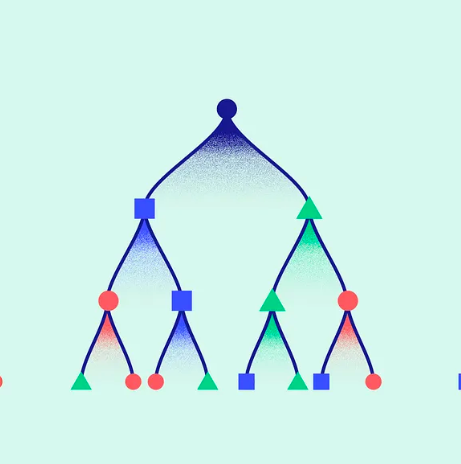

In [11]:
from IPython import display

display.Image("../data/pictures/img_1.png")

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import optuna
import xgboost as xgb

In [13]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [14]:
df = pd.read_csv('../data/extract/data.csv')

In [15]:
df.head()

,Unnamed: 0,Цена соевого масла_Роттердам__root_mean_square_x,Цена сырого пальмового масла__maximum_x,Цена сырого пальмового масла__root_mean_square_x,"Цена соевого масла_Роттердам__linear_trend__attr_""pvalue""_X1",Цена соевого масла_Аргентина__standard_deviation_X1,Цена пальмового масла_Аргентина__root_mean_square_X1,Цена соевого масла_Аргентина__variance_X1,Цена соевого масла_Бразилия__standard_deviation_X1,Цена соевого масла_Бразилия__variance_X1,...,Цена соевого масла_Бразилия__length_week,Цена соевого масла_Бразилия__mean_week,Цена соевого масла_Бразилия__median_week,Цена соевого масла_Бразилия__sum_values_week,"Цена соевого масла_Аргентина__linear_trend__attr_""slope""_week","Цена соевого масла_Аргентина__linear_trend__attr_""pvalue""_week",Цена соевого масла_Аргентина__minimum_week,Цена сырого пальмового масла__median_week,date,Цена сырого пальмового масла
0,0,897.281784,1485.0,871.823491,3.068082e-52,233.296209,977.98713,54427.121024,235.145601,55293.453658,...,682.0,947.196334,878.0,645987.9,0.108246,0.040672,555.57,765.000,2011-01-17,1215.0
1,1,897.281784,1485.0,871.823491,3.068082e-52,233.296209,977.98713,54427.121024,235.145601,55293.453658,...,682.0,946.779912,873.6,645703.9,0.106434,0.043488,556.01,768.125,2011-01-18,1205.0
2,2,897.281784,1485.0,871.823491,3.068082e-52,233.296209,977.98713,54427.121024,235.145601,55293.453658,...,681.0,947.314831,874.6,645121.4,0.109991,0.038626,547.19,765.000,2011-01-19,1245.0
3,3,897.281784,1485.0,871.823491,3.068082e-52,233.296209,977.98713,54427.121024,235.145601,55293.453658,...,681.0,946.309104,875.7,644436.5,0.101916,0.053841,552.04,767.500,2011-01-20,1245.0
4,4,897.281784,1485.0,871.823491,3.068082e-52,233.296209,977.98713,54427.121024,235.145601,55293.453658,...,681.0,946.632159,873.7,644656.5,0.107420,0.042281,561.74,767.500,2011-01-21,1255.0


In [16]:
X = df.drop(['Цена сырого пальмового масла', 'date'], axis=1)
y = df['Цена сырого пальмового масла']

Будем обучать модель при помощи специальной кросс-валидации для временных рядов, а для подбора гиперапараметров - библиотеку optuna.

In [17]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'eval_metric': 'mape',
        'verbosity': 0,
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.1, 2.0),
        'alpha': trial.suggest_float('alpha', 0.1, 2.0),
        'nthread': -1
    }

    tscv = TimeSeriesSplit(n_splits=100)
    mape_arr = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(param, dtrain, evals=[(dtrain, 'train'), (dval, 'eval')],
                          early_stopping_rounds=50, verbose_eval=False)

        y_pred = model.predict(dval)

        mape_arr.append(mape(y_test, y_pred))

    return np.mean(mape_arr) + np.std(mape_arr)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-04-16 21:37:45,051] A new study created in memory with name: no-name-f6c0901f-3a29-499b-9023-690e2fe25ac4
[I 2024-04-16 21:37:57,527] Trial 0 finished with value: 28.387702114826354 and parameters: {'eta': 0.1170809769191922, 'max_depth': 3, 'subsample': 0.5572231842996394, 'colsample_bytree': 0.5934575740816906, 'lambda': 0.1799826671193709, 'alpha': 1.8224128403733448}. Best is trial 0 with value: 28.387702114826354.
[I 2024-04-16 21:38:11,424] Trial 1 finished with value: 32.82678391836136 and parameters: {'eta': 0.06657021625794901, 'max_depth': 7, 'subsample': 0.696272562075995, 'colsample_bytree': 0.6025040183353856, 'lambda': 0.3391921469779011, 'alpha': 1.0635595812838605}. Best is trial 0 with value: 28.387702114826354.
[I 2024-04-16 21:38:25,575] Trial 2 finished with value: 31.4619097658181 and parameters: {'eta': 0.06598946345775096, 'max_depth': 9, 'subsample': 0.957512286207918, 'colsample_bytree': 0.6774594178039605, 'lambda': 1.612937565019731, 'alpha': 1.164302

In [21]:
best_params = study.best_params

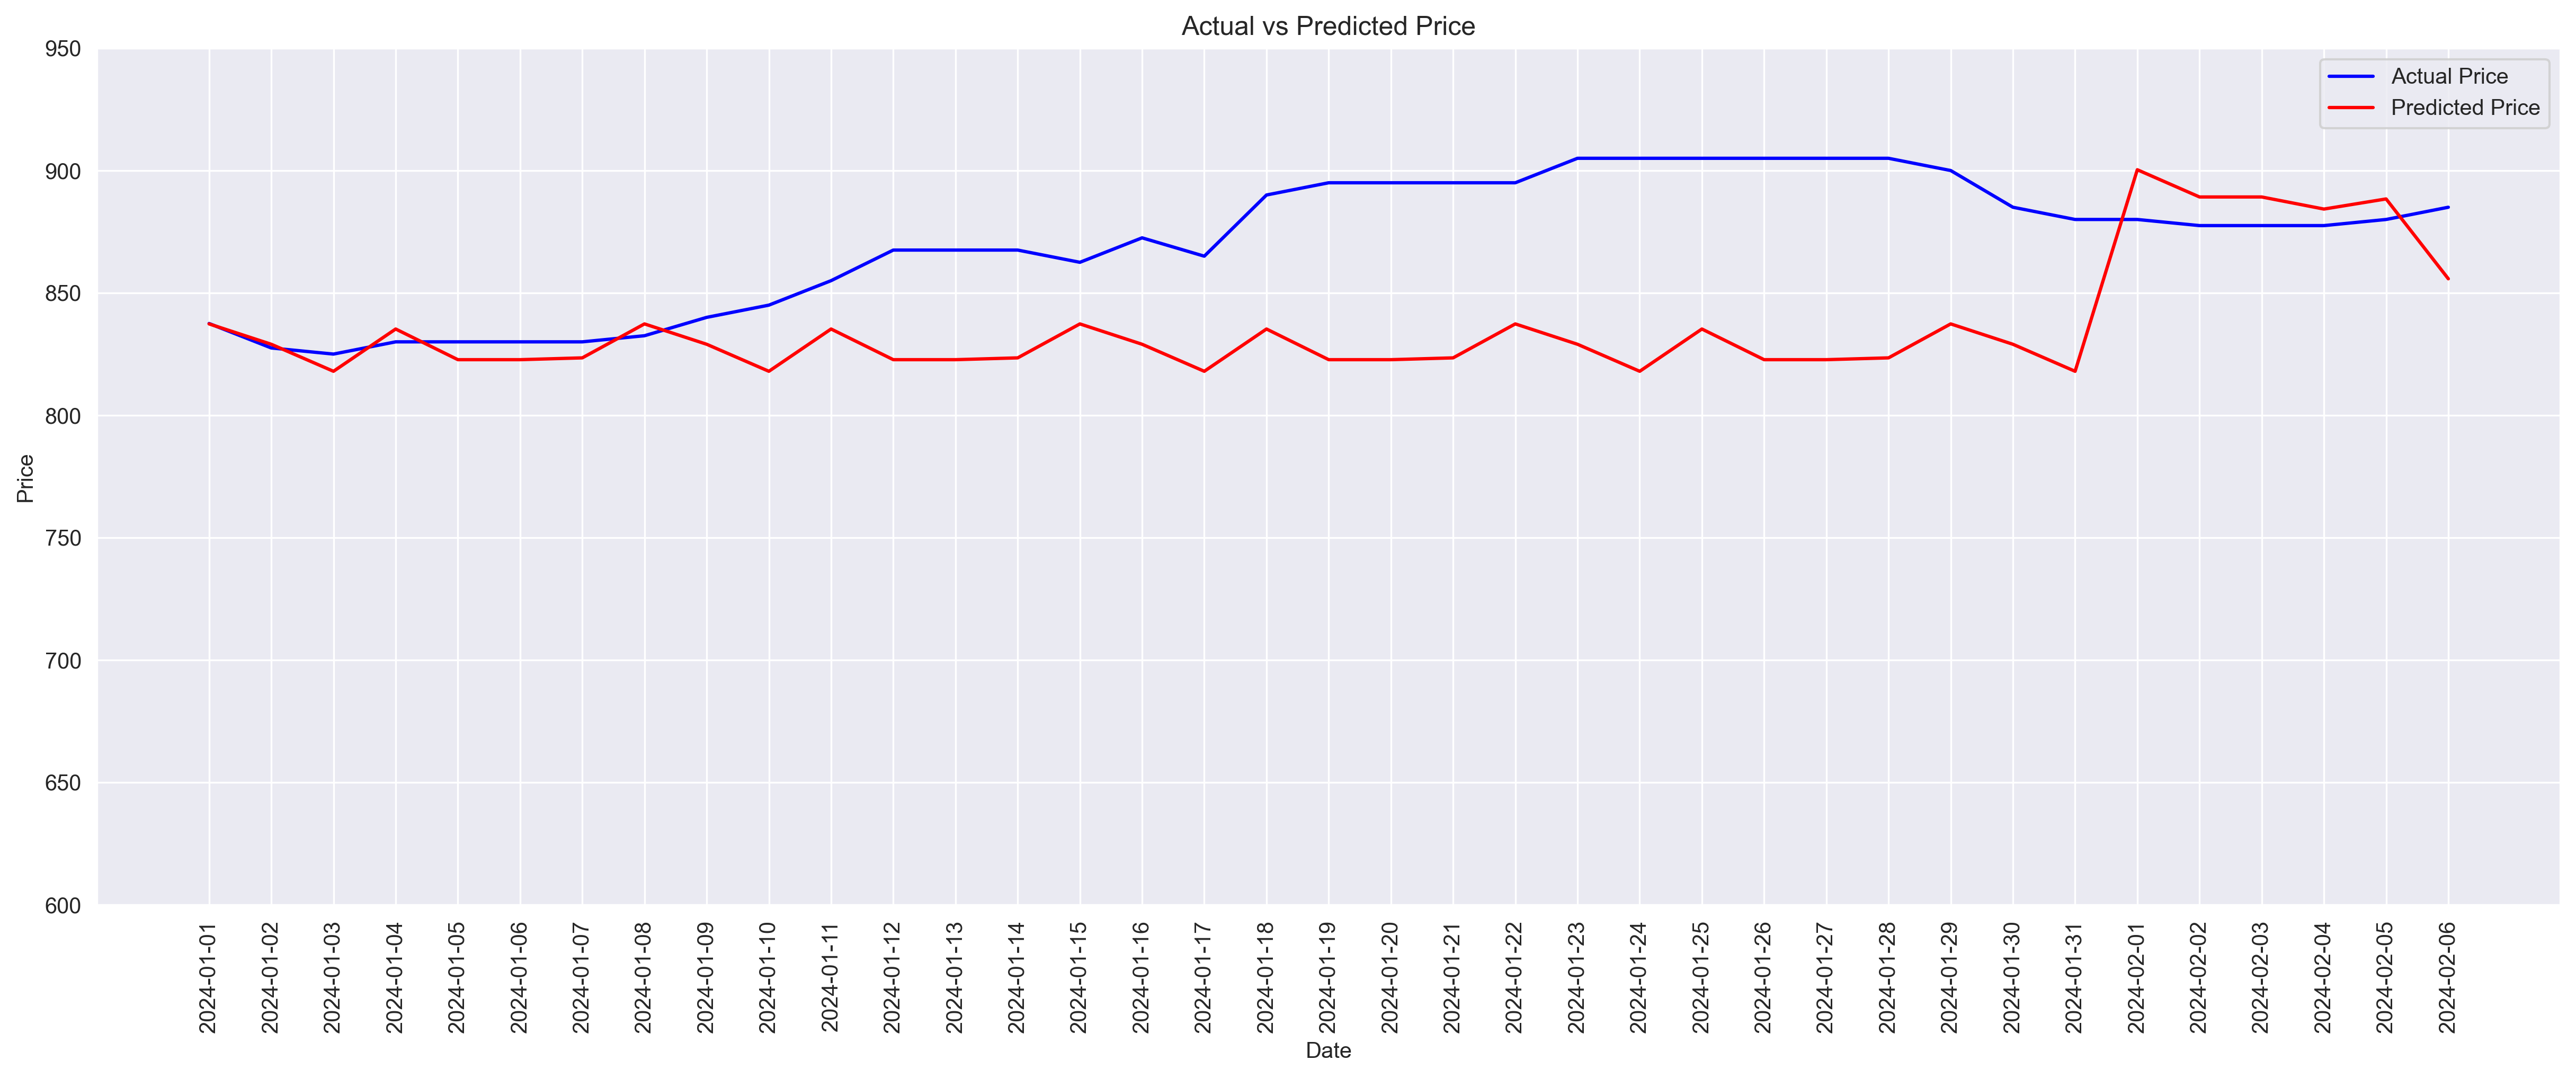

MAPE 4.334409832186849


In [22]:
best_model = xgb.XGBRegressor(**best_params)

train = df.set_index('date').loc[:'2024-01-01']
test = df.set_index('date').loc['2024-01-01':]


X_train = train.drop('Цена сырого пальмового масла', axis=1)
y_train = train['Цена сырого пальмового масла']

X_test = test.drop('Цена сырого пальмового масла', axis=1)
y_test = test['Цена сырого пальмового масла']


best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)


plt.figure(figsize=(20, 7), dpi=300)
plt.plot(X_test.index, y_test, label='Actual Price', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Price', color='red')  # Возврат к исходной шкале
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.ylim(600, 950)
plt.title('Actual vs Predicted Price')
plt.legend()
plt.show()

print("MAPE", mape(y_test, y_pred))

In [20]:
booster = xgb.XGBRegressor(**best_params)
booster.fit(X, y)
booster.save_model('../models/xgboost_model.json')

In [23]:
def objective(trial):
    param = {
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',
        'eval_metric': 'mape',
        'verbosity': 0,
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.1, 2.0),
        'alpha': trial.suggest_float('alpha', 0.1, 2.0),
        'nthread': -1
    }

    tscv = TimeSeriesSplit(n_splits=100)
    mape_arr = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(param, dtrain, evals=[(dtrain, 'train'), (dval, 'eval')],
                          early_stopping_rounds=50, verbose_eval=False)

        y_pred = model.predict(dval)

        mape_arr.append(mape(y_test, y_pred))

    return np.mean(mape_arr) + np.std(mape_arr)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-04-16 22:02:17,685] A new study created in memory with name: no-name-838f459e-06ac-4fb3-b678-dd8df403b8c2
[I 2024-04-16 22:02:31,458] Trial 0 finished with value: 38.43736187760396 and parameters: {'eta': 0.015083914556132727, 'max_depth': 9, 'subsample': 0.5397874050840773, 'colsample_bytree': 0.9810977507213346, 'lambda': 1.0995839275873713, 'alpha': 0.6206364999963938}. Best is trial 0 with value: 38.43736187760396.
[I 2024-04-16 22:02:43,998] Trial 1 finished with value: 23.954949941901596 and parameters: {'eta': 0.18140338603484563, 'max_depth': 5, 'subsample': 0.6498554439255048, 'colsample_bytree': 0.6861623092864925, 'lambda': 1.6346877291207298, 'alpha': 1.9704943047647931}. Best is trial 1 with value: 23.954949941901596.
[I 2024-04-16 22:02:56,856] Trial 2 finished with value: 29.809361588672353 and parameters: {'eta': 0.12325441646984325, 'max_depth': 7, 'subsample': 0.520440907478378, 'colsample_bytree': 0.6556645904839213, 'lambda': 1.0762958341515432, 'alpha': 0.5

In [25]:
best_params = study.best_params

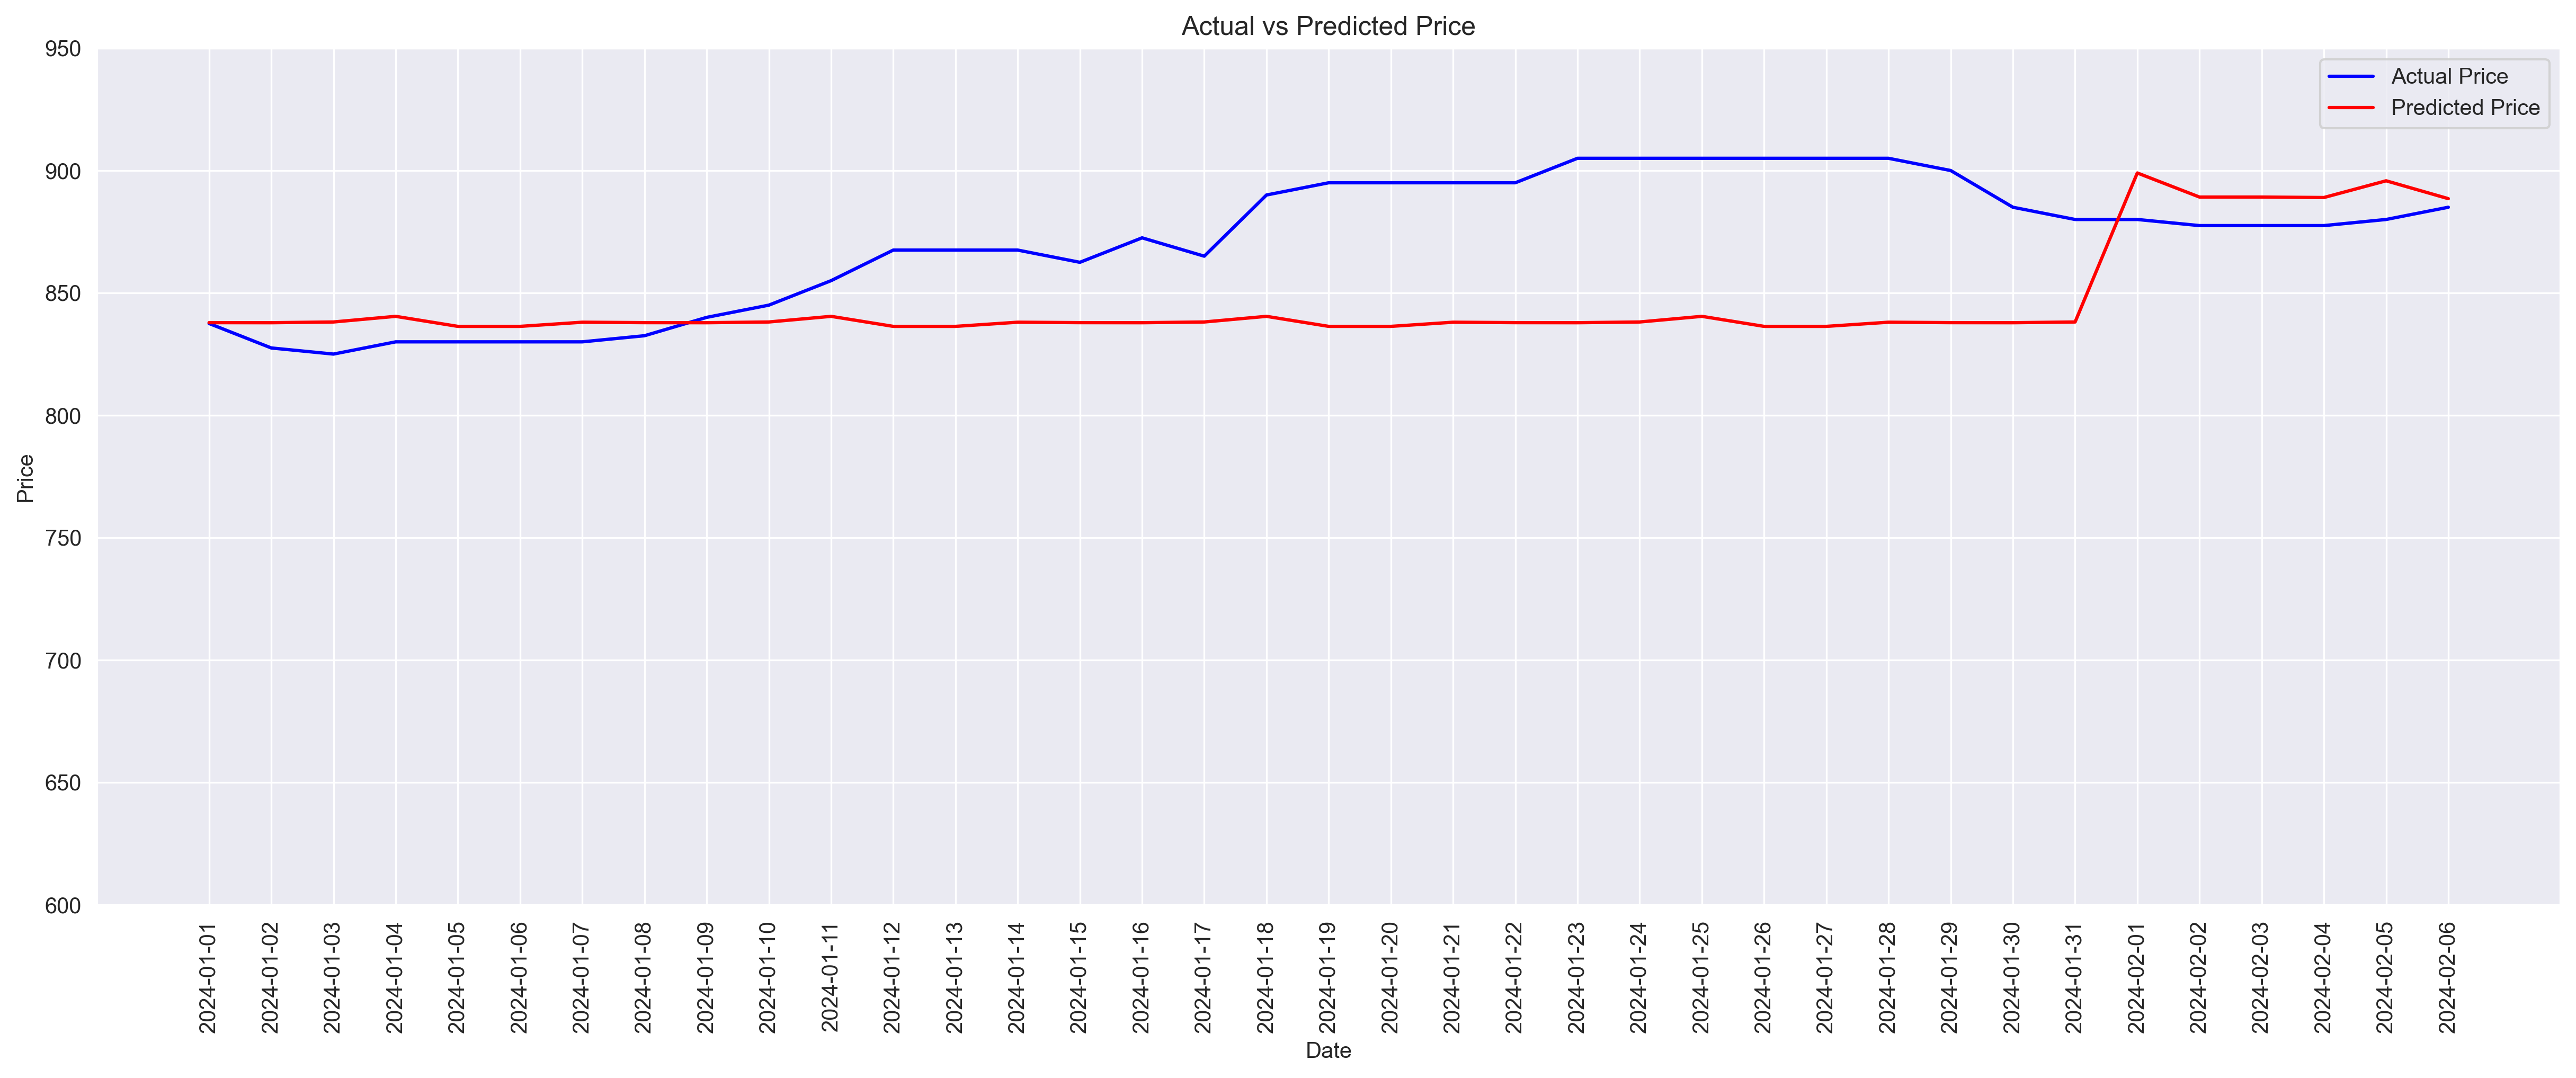

MAPE 3.563493452297848


In [26]:
best_model = xgb.XGBRegressor(**best_params)

train = df.set_index('date').loc[:'2024-01-01']
test = df.set_index('date').loc['2024-01-01':]


X_train = train.drop('Цена сырого пальмового масла', axis=1)
y_train = train['Цена сырого пальмового масла']

X_test = test.drop('Цена сырого пальмового масла', axis=1)
y_test = test['Цена сырого пальмового масла']


best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)


plt.figure(figsize=(20, 7), dpi=300)
plt.plot(X_test.index, y_test, label='Actual Price', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Price', color='red')  # Возврат к исходной шкале
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.ylim(600, 950)
plt.title('Actual vs Predicted Price')
plt.legend()
plt.show()

print("MAPE", mape(y_test, y_pred))

In [27]:
booster = xgb.XGBRegressor(**best_params)
booster.fit(X, y)
booster.save_model('../models/xgboost_model_loss_mae.json')

MAPE 3.56 - прогноз модели отклоняется на 3.56% при прогнозировании на месяц. Результат можно назвать удовлетворительным. 